In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="raj@2003",
                           database="ecommerce")



cur=db.cursor()


#List all unique cities where customers are located. 
query="""select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
df2=pd.DataFrame(data)
df2.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [28]:
#count the number of orders placedin 2017
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
data

"total orders plaxed in 2017 are",data[0][0]

('total orders plaxed in 2017 are', 45101)

In [31]:
#find total sales per category 
query="""select products.product_category category,round(sum(payments.payment_value),2)
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""
cur.execute(query)
data=cur.fetchall()
data

df1=pd.DataFrame(data,columns=["category","sales"])
df1

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


In [16]:
#calculate the percentage of orders that were paid in installments
query="""select (sum(case when payment_installments >=1 then 1
else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data
"the percentage of orders that were paid in installments is ",data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

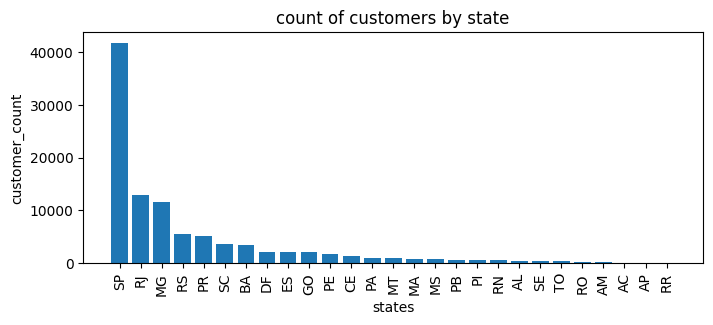

In [58]:
#count the number of customers from each state
query="""select customer_state, count(customer_id) from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count",ascending= False)
plt.figure(figsize=(8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("count of customers by state")
plt.show()

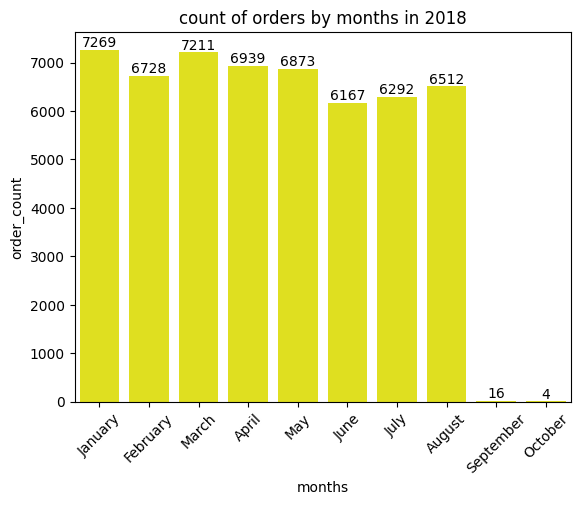

In [63]:
#calculate the number of orders per month in 2018
query="""select monthname(order_purchase_timestamp) months,count(order_id)from orders
where year(order_purchase_timestamp)=2018
group by months"""
cur.execute(query)
data=cur.fetchall()
df3=pd.DataFrame(data,columns=["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]

ax=sns.barplot(x=df3["months"],y=df3["order_count"],data=df3,order=o,color= "yellow")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("count of orders by months in 2018")
plt.show()



In [10]:
#find the average number of products per order,grouped by customer city.
query="""with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items on orders.order_id =order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_order desc"""
cur.execute(query)
data=cur.fetchall()
df4=pd.DataFrame(data,columns=["customer city","average order"])
df4.head(10)

,customer city,average order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


In [27]:
#calculate the percentage of total revenue contributed by each product category
query=""" select products.product_category category,round((sum(payments.payment_value)/(select sum(payment_value)
from payments))*100,2) as sales_percentage
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category order by sales_percentage desc"""
cur.execute(query)
data=cur.fetchall()
df5=pd.DataFrame(data,columns=["category","percentage contribution"])
df5.head(10)

,category,percentage contribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


In [31]:
#Identify the correlation between product price and the number of times a product has been purchased.
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


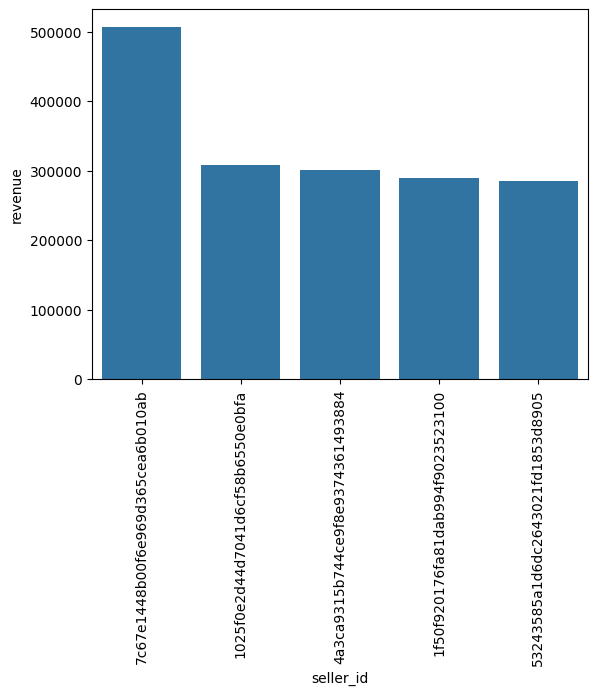

In [32]:
#Calculate the total revenue generated by each seller, and rank them by revenue
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()
